## Data Loading

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


In [61]:
df_tweets = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df_tweets[:10]

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [62]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


## Data Cleaning
### Deleting Missing Values

In [63]:
def check_missing_values(col):
    counter = 0
    for element in col:
        if element == True:
            counter += 1
    return counter

In [64]:
df_tweets.isnull().apply(lambda x: check_missing_values(x))

tweet_text            0
cyberbullying_type    0
dtype: int64

### Deleting Duplicated Values

In [65]:
def check_duplicated_values(x):
    return x.duplicated().sum()

In [66]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text             1675
cyberbullying_type    47686
dtype: int64

In [67]:
df_tweets.loc[:,["tweet_text"]].duplicated().sum()

1675

In [68]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet_text'])

In [69]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text                0
cyberbullying_type    46011
dtype: int64

In [70]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


## Data Transformation
### Balancing the Dataset

In [71]:
df_tweets = df_tweets.groupby(by="cyberbullying_type").sample(n=1000, random_state=1)
print("Length: "+ str(len(df_tweets)))
df_tweets[:5]

Length: 6000


,tweet_text,cyberbullying_type
34044,She looks so beautiful and she’s has a very ki...,age
38234,My old high school bully just tried to menace ...,age
36306,From my experience PE teachers are bullies. I ...,age
36793,ew why is gun/poop girl trending literally go ...,age
37263,Lara Spencer is so unprofessional. She bullied...,age


In [72]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,1000
ethnicity,1000
gender,1000
not_cyberbullying,1000
other_cyberbullying,1000
religion,1000


### Splitting Test and Train/Validation sets
I will create a test set. A set not touched to evaluation later on the model performance.

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
df_x_tv, df_x_test, df_y_tv, df_y_test = train_test_split(df_tweets['tweet_text'], df_tweets['cyberbullying_type'], test_size=0.20,random_state=42)

## Data Preprocessing
We are going to create a list of tokens to be used in the RNN model. A term-document to be used as input into the model. Furthermore, a version without stopwords.
### Tokenization

In [75]:
import spacy

nlp = spacy.load('en_core_web_sm')

# to be used in the without stopwords version
all_stopwords = nlp.Defaults.stop_words

In [76]:
# Remove URLs
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

In [77]:
import re

def tokenize_without_stopwords(cell):
    nlp_text = nlp(cell)
    tokens = [remove_urls(token.text).lower() for token in nlp_text if token.text.isalnum() and not token.text in all_stopwords]
    return tokens

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

term_doc_m = CountVectorizer(tokenizer=tokenize_without_stopwords,max_df=0.8,min_df=0.01,max_features=4000)

In [79]:
term_doc_m.fit(df_x_tv)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(max_df=0.8, max_features=4000, min_df=0.01,
                tokenizer=<function tokenize_without_stopwords at 0x7fb3a29710e0>)

In [80]:
df_x = term_doc_m.transform(df_x_tv)
df_x.shape

(4800, 140)

In [81]:
df_x_test = term_doc_m.transform(df_x_test)
df_x_test.shape

(1200, 140)

### Hot Encoding

In [82]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_tweets['cyberbullying_type'])
print('Labels: ', label_encoder.classes_)


def label_encode(labels):
    encoding = label_encoder.transform(labels)
    return tf.keras.utils.to_categorical(encoding,len(label_encoder.classes_))


def label_decode(labels):
    decoding = np.argmax(labels, axis=1)
    return label_encoder.inverse_transform(decoding)

Labels:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']


In [83]:
label_encode(['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [84]:
df_y = label_encode(df_y_tv)
df_y[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [85]:
df_y_test = label_encode(df_y_test)
df_y_test[:5]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

### Spliting the Dataset in the Train, Validation and Testing Sets

In [86]:
from sklearn.model_selection import train_test_split

df_x_train, df_x_valid, df_y_train, df_y_valid = train_test_split(df_x, df_y, test_size=0.30,random_state=42)

In [87]:
counter = {}

labels = ['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion']
comparater = label_encode(labels)

#init
def initCounter():
    for i in label_encoder.classes_:
        counter[i] = 0

def countCategories(x):
    for idx, y in enumerate(comparater):
        if (x == y).all():
            counter[labels[idx]] = counter[labels[idx]] + 1
            return      

In [88]:
initCounter()
for i in df_y_train:
    countCategories(i)
    
counter

{'age': 552,
 'ethnicity': 525,
 'gender': 575,
 'not_cyberbullying': 556,
 'other_cyberbullying': 590,
 'religion': 562}

In [89]:
initCounter()
for i in df_y_valid:
    countCategories(i)
    
counter  

{'age': 233,
 'ethnicity': 253,
 'gender': 249,
 'not_cyberbullying': 240,
 'other_cyberbullying': 221,
 'religion': 244}

In [90]:
initCounter()
for i in df_y_test:
    countCategories(i)
    
counter  

{'age': 215,
 'ethnicity': 222,
 'gender': 176,
 'not_cyberbullying': 204,
 'other_cyberbullying': 189,
 'religion': 194}

## Modeling
### Creating Model

In [91]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
#regularizer = tf.keras.regularizers.l1_l2(0.001, 0)
classes_len = len(label_encoder.classes_)

In [92]:
input_shape = len(term_doc_m.get_feature_names())

# tf.keras.layers.Input(shape=(input_shape,)),

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(1, input_shape), return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(50, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(classes_len, kernel_regularizer=regularizer),
    tf.keras.layers.Softmax()
])

model.summary()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 100)            96400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
_________________________________________________________________
softmax_2 (Softmax)          (None, 6)                

### Compiling

In [93]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

### Defining Hyperparameters

In [94]:
epoch = 15
batch = 40

### Converting Dataframe from 2d to 3d for the LSTM Layer

In [95]:
df_x_train_3d = []
for row in df_x_train:
    df_x_train_3d.append(row.toarray())
    
df_x_train_3d = np.array(df_x_train_3d)

In [96]:
df_x_train_3d.shape

(3360, 1, 140)

In [97]:
df_x_train_3d[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0]])

In [98]:
df_x_valid_3d = []
for row in df_x_valid:
    df_x_valid_3d.append(row.toarray())
    
df_x_valid_3d = np.array(df_x_valid_3d)

### Training Values

In [99]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [100]:
history = model.fit(df_x_train_3d, df_y_train, epochs=epoch, batch_size=batch, validation_data=(df_x_valid_3d,df_y_valid))

Epoch 1/15
 3/84 [>.............................] - ETA: 3s - loss: 1.8511 - accuracy: 0.1917

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


84/84 [==============================] - 4s 53ms/step - loss: 1.6386 - accuracy: 0.4057 - val_loss: 1.0170 - val_accuracy: 0.5986
Epoch 2/15
84/84 [==============================] - 4s 53ms/step - loss: 0.7256 - accuracy: 0.7268 - val_loss: 0.6414 - val_accuracy: 0.7722
Epoch 3/15
84/84 [==============================] - 5s 54ms/step - loss: 0.5833 - accuracy: 0.7747 - val_loss: 0.6135 - val_accuracy: 0.7778
Epoch 4/15
84/84 [==============================] - 5s 55ms/step - loss: 0.5391 - accuracy: 0.7958 - val_loss: 0.5991 - val_accuracy: 0.7799
Epoch 5/15
84/84 [==============================] - 4s 53ms/step - loss: 0.5162 - accuracy: 0.7949 - val_loss: 0.5915 - val_accuracy: 0.7903
Epoch 6/15
84/84 [==============================] - 5s 56ms/step - loss: 0.5061 - accuracy: 0.8018 - val_loss: 0.6027 - val_accuracy: 0.7889
Epoch 7/15
84/84 [==============================] - 5s 56ms/step - loss: 0.4953 - accuracy: 0.8086 - val_loss: 0.5909 - val_accuracy: 0.7917
Epoch 8/15
84/84 [======

### Evaluating Results

In [101]:
import matplotlib.pyplot as plt

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

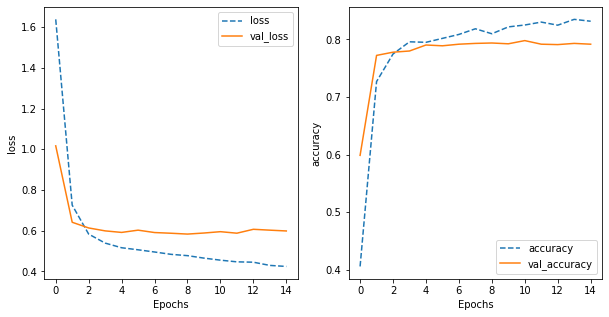

In [102]:
training_plot(['loss', 'accuracy'], history)

## Testing Model
### Converting Array from 2d to 3d

In [107]:
df_x_test_3d = []
for row in df_x_test:
    df_x_test_3d.append(row.toarray())
    
df_x_test_3d = np.array(df_x_test_3d)

### Making the Predictions

In [108]:
df_y_test_pred = model.predict(df_x_test_3d)

### Classification Report

In [109]:
pred_result = label_decode(df_y_test_pred)
true_result = label_decode(df_y_test)
print(classification_report(y_true=true_result, y_pred=pred_result))

                     precision    recall  f1-score   support

                age       0.98      0.95      0.97       215
          ethnicity       1.00      0.95      0.97       222
             gender       0.88      0.73      0.80       176
  not_cyberbullying       0.56      0.37      0.44       204
other_cyberbullying       0.46      0.74      0.57       189
           religion       0.93      0.93      0.93       194

           accuracy                           0.78      1200
          macro avg       0.80      0.78      0.78      1200
       weighted avg       0.81      0.78      0.79      1200



### Confusion Matrix

In [110]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [115]:
# Funtion for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    classes.sort()
    tick_marks = np.arange(len(classes))    
    plt.figure(figsize=(7, 7),dpi=115)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


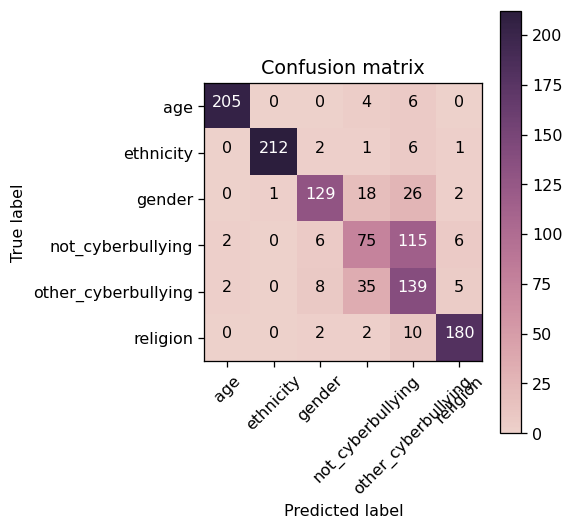

In [114]:
cm = confusion_matrix(y_true=true_result, y_pred=pred_result) 
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')

## Finals Thoughts
I got similar results to my DNN versions. A similar level of overfitting. The real challenge in the model is separate: not cyberbullying vs other cyberbullying. Because both categories don't belong to some specific category, type of data, or usual pattern. Its scope is bigger than the other categories, making it difficult to difference its key patterns. 

Furthermore, we use a minimun frequency value to avoid terms that ocurred less than 1%, or terms that ocurred over 80% of the dataset.